# Surrogate Model
### Training of Feedforward Neural Network with special architecture for Ordinal Classification

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import pickle
os.chdir("..")
from sklearn.preprocessing import StandardScaler
from src.models.ordinal_classifier_fnn import *
from src.models.coral_loss import *
from src.data.sm_dataloader import *
from src.preprocessing.sm_label_transformer import *
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error

### 1. Set seeds

In [2]:
# Set seeds in order to reproduce results
torch.manual_seed(73)
random.seed(73)
np.random.seed(73)

### 2. Load dataset

In [3]:
# Replace by true labeled dataset if available
train_dataset = DatasetSM(train=True, path="data/surrogate_model")
test_dataset = DatasetSM(train=False, path="data/surrogate_model")
train_dataset.X.shape

torch.Size([10769, 38])

In [4]:
train_dataset.X

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0395,  0.0514, 24.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.7143,  0.7070, 24.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.7143,  0.7786, 24.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.8615,  0.5000, 24.0000],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.6105,  0.4907, 24.0000],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.8615,  0.5000, 24.0000]])

In [5]:
train_dataset.y

tensor([[1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        ...,
        [1., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

### 3. Scale training and test data

In [6]:
scaler = StandardScaler()

# only scale numeric variables that are not one-hot encoded
scaler.fit(train_dataset.X[:, 12:])
train_dataset.scale(scaler)
test_dataset.scale(scaler)

with open('models/sm_train_standard_scaler.pkl', 'wb') as output:
    pickle.dump(scaler, output, pickle.HIGHEST_PROTOCOL)

In [7]:
train_dataset.X

tensor([[ 0.0000,  0.0000,  0.0000,  ..., -1.8879, -1.9880,  0.0212],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.8339,  0.9340,  0.0212],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.8339,  1.2531,  0.0212],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  1.4277,  0.0115,  0.0212],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.4151, -0.0298,  0.0212],
        [ 0.0000,  1.0000,  0.0000,  ...,  1.4277,  0.0115,  0.0212]])

### 4. Upscaling of class 4/"Very Good" (optional, was shown to not improve the performance)

In [8]:
# Get indices where data label equals 4
#label_counts = {i: len(np.where(torch.sum(train_dataset.y, axis=1) == i)[0]) for i in range(5)}
#i_class4 = np.where(torch.sum(train_dataset.y, axis=1) == 4)[0]
# Calculate upsample size (mean of class sizes 0-3 - class size 4)
#upsample_size = round(np.mean([label_counts[i] for i in range(4)])) - label_counts[4]
# Get upsample indices
#i_class4_upsampled = np.random.choice(i_class4, size=upsample_size, replace=True)

In [9]:
# Create upsampled dataframe
#train_dataset.y = torch.vstack([train_dataset.y, train_dataset.y[i_class4_upsampled]])
#train_dataset.X = torch.vstack([train_dataset.X, train_dataset.X[i_class4_upsampled]])
#train_dataset.X.shape

### 5. Train model

#### 5.1 Build model and switch to GPU if available

In [10]:
fitness_function = OrdinalClassifierFNN(num_classes=5, layer_sizes=[38,28])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
fitness_function.to(device)

cpu


OrdinalClassifierFNN(
  (hidden): ModuleList(
    (0): Linear(in_features=38, out_features=28, bias=True)
  )
  (coral_weights): Linear(in_features=28, out_features=1, bias=False)
)

In [11]:
res = fitness_function(test_dataset.X[:5])
print(res)
torch.sigmoid(res)

tensor([[ 0.6248,  0.3748,  0.1248, -0.1252],
        [ 0.6248,  0.3748,  0.1248, -0.1252],
        [ 0.5964,  0.3464,  0.0964, -0.1536],
        [ 0.6248,  0.3748,  0.1248, -0.1252],
        [ 0.5227,  0.2727,  0.0227, -0.2273]], grad_fn=<AddBackward0>)


tensor([[0.6513, 0.5926, 0.5312, 0.4687],
        [0.6513, 0.5926, 0.5312, 0.4687],
        [0.6448, 0.5858, 0.5241, 0.4617],
        [0.6513, 0.5926, 0.5312, 0.4687],
        [0.6278, 0.5678, 0.5057, 0.4434]], grad_fn=<SigmoidBackward>)

#### 5.2 Define optimizer and additional measure to report (optional)

In [12]:
#criterion = nn.L1Loss()
report_measure = nn.L1Loss()
optimizer = torch.optim.Adam(fitness_function.parameters())

#### 5.3 Define Data loaders

In [13]:
# Useful because it automatically generates batches in the training loop and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

#### 5.4 Actual Model training

In [14]:
n_epochs = 100

# Stuff to store
train_losses = np.zeros(n_epochs)
train_bin_maes = np.zeros(n_epochs)
train_accuracies = np.zeros(n_epochs)
train_label_maes = np.zeros(n_epochs)

test_losses = np.zeros(n_epochs)
test_bin_maes = np.zeros(n_epochs)
test_accuracies = np.zeros(n_epochs)
test_label_maes = np.zeros(n_epochs)


for it in range(n_epochs):
    train_loss = []
    test_loss = []
    train_bin_mae = []
    test_bin_mae = []
    train_label_mae = []
    test_label_mae = []
    correct_train = 0
    correct_test = 0
    for inputs, targets in train_loader:
        # move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = fitness_function(inputs)
        loss = coral_loss(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Store loss and other report measures
        train_loss.append(loss.item())
        train_bin_mae.append(report_measure(torch.sigmoid(outputs), targets).item())
        train_label_mae.append(mean_absolute_error(decode_classes(targets), decode_classes(torch.sigmoid(outputs))))
        
        # Count correct predictions
        correct_train += (decode_classes(torch.sigmoid(outputs)) == decode_classes(targets)).sum()
        
    # Get train loss and test loss
    train_loss = np.mean(train_loss)
    train_bin_mae = np.mean(train_bin_mae)
    train_label_mae = np.mean(train_label_mae)
    
    # Get train accuracy
    train_accuracy = correct_train / len(train_dataset.X)
    
    predicted_classes = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = fitness_function(inputs)
        loss = coral_loss(outputs, targets)
        test_loss.append(loss.item())
        test_bin_mae.append(report_measure(torch.sigmoid(outputs), targets).item())
        test_label_mae.append(mean_absolute_error(decode_classes(targets), decode_classes(torch.sigmoid(outputs))))
        correct_test += (decode_classes(torch.sigmoid(outputs)) == decode_classes(targets)).sum()
    test_loss = np.mean(test_loss)
    test_bin_mae = np.mean(test_bin_mae)
    test_label_mae = np.mean(test_label_mae)
    test_accuracy = correct_test / len(test_dataset.X)

    # Save losses
    train_losses[it] = train_loss
    train_bin_maes[it] = train_bin_mae
    test_losses[it] = test_loss
    test_bin_maes[it] = test_bin_mae
    train_label_maes[it] = train_label_mae
    test_label_maes[it] = test_label_mae
    train_accuracies[it] = train_accuracy
    test_accuracies[it] = test_accuracy

    if (it + 1) % 10 == 0 or it==0:
        print(f'Epoch {it + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}'
              f' Train Binary MAE: {train_bin_mae:.4f}, Test Binary MAE: {test_bin_mae:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}, Train Label MAE:  {train_label_mae:.4f}, Test Label MAE:  {test_label_mae:.4f}')

Epoch 1/100, Train Loss: 2.4163, Test Loss: 2.2970 Train Binary MAE: 0.4421, Test Binary MAE: 0.4197, Train Accuracy: 0.2672, Test Accuracy: 0.2888, Train Label MAE:  1.1985, Test Label MAE:  1.1493
Epoch 10/100, Train Loss: 1.8310, Test Loss: 1.8372 Train Binary MAE: 0.3317, Test Binary MAE: 0.3310, Train Accuracy: 0.4545, Test Accuracy: 0.4557, Train Label MAE:  0.7364, Test Label MAE:  0.7264
Epoch 20/100, Train Loss: 1.6852, Test Loss: 1.7109 Train Binary MAE: 0.2936, Test Binary MAE: 0.2937, Train Accuracy: 0.4415, Test Accuracy: 0.4475, Train Label MAE:  0.7202, Test Label MAE:  0.7115
Epoch 30/100, Train Loss: 1.6260, Test Loss: 1.6600 Train Binary MAE: 0.2737, Test Binary MAE: 0.2762, Train Accuracy: 0.4404, Test Accuracy: 0.4411, Train Label MAE:  0.7143, Test Label MAE:  0.7125
Epoch 40/100, Train Loss: 1.5969, Test Loss: 1.6608 Train Binary MAE: 0.2634, Test Binary MAE: 0.2684, Train Accuracy: 0.4366, Test Accuracy: 0.4350, Train Label MAE:  0.7135, Test Label MAE:  0.7180
E

### 6. Evaluate model performance

#### 6.1 Compute benchmark performance values

In [15]:
unique_train, counts_train = np.unique(decode_classes(train_dataset.y).flatten(), return_counts=True)
display(len(train_dataset))
dict(zip(unique_train, counts_train))

10769

{0: 2580, 1: 2143, 2: 3752, 3: 1892, 4: 402}

In [16]:
unique_test, counts_test = np.unique(decode_classes(test_dataset.y).flatten(), return_counts=True)
display(len(test_dataset.y))
dict(zip(unique_test, counts_test))

2469

{0: 498, 1: 414, 2: 918, 3: 532, 4: 107}

In [17]:
# Accuracy for majority classifier
print(f'Test Benchmark Accuracy: {918/2469 :.4f}')

Test Benchmark Accuracy: 0.3718


In [18]:
# Label MAE for constant prediction of class 2
print(f'Test Benchmark Label MAE: {2*(498+107)/2469 + 1*(414+532)/2469 :.4f}')

Test Benchmark Label MAE: 0.8732


In [19]:
# Binary MAE for constant prediction of class 2 (1,1,0,0)
print(f'Test Benchmark Binary MAE: {(498*0.5 + 414*0.25 + 532*0.25 + 107*0.5)/2469 :.4f}')

Test Benchmark Binary MAE: 0.2183


#### 6.2 Plot the train loss and test loss per epoch

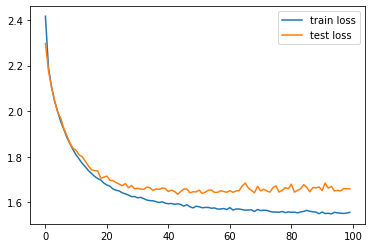

In [20]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

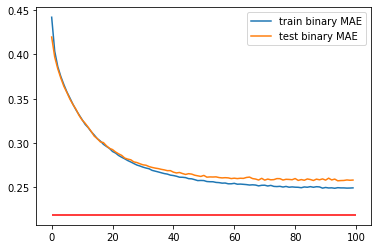

In [21]:
plt.plot(train_bin_maes, label='train binary MAE')
plt.plot(test_bin_maes, label='test binary MAE')
plt.hlines(0.2183, xmin=0, xmax=100, color='red')
plt.legend()
plt.show()

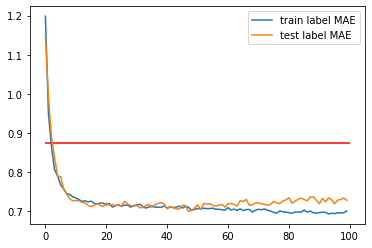

In [22]:
plt.plot(train_label_maes, label='train label MAE')
plt.plot(test_label_maes, label='test label MAE')
plt.hlines(0.8732, xmin=0, xmax=100, color='red')
plt.legend()
plt.show()

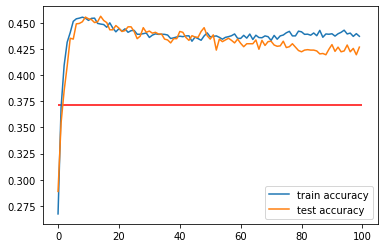

In [24]:
plt.plot(train_accuracies, label='train accuracy')
plt.plot(test_accuracies, label='test accuracy')
plt.hlines(0.3718, xmin=0, xmax=100, color='red')
plt.legend()
plt.show()

### 7. Save and load trained model

#### 7.1 Save model

In [25]:
torch.save(fitness_function.state_dict(), "models/sm_fnn.pth")

#### 7.2. Load model and make predictions

In [26]:
model = OrdinalClassifierFNN(num_classes=5, layer_sizes=[38,28])
model.load_state_dict(torch.load("models/sm_fnn.pth"))
model.eval()

OrdinalClassifierFNN(
  (hidden): ModuleList(
    (0): Linear(in_features=38, out_features=28, bias=True)
  )
  (coral_weights): Linear(in_features=28, out_features=1, bias=False)
)

In [27]:
inp = test_dataset.X[0:20]
output = model(inp)

In [28]:
output

tensor([[ 1.2769,  0.0710, -1.8730, -3.9868],
        [ 1.2769,  0.0710, -1.8730, -3.9868],
        [-1.2710, -2.4769, -4.4209, -6.5347],
        [ 1.2769,  0.0710, -1.8730, -3.9868],
        [ 1.1743, -0.0317, -1.9756, -4.0895],
        [ 1.7814,  0.5754, -1.3685, -3.4824],
        [ 1.9529,  0.7470, -1.1970, -3.3108],
        [ 1.2769,  0.0710, -1.8730, -3.9868],
        [ 1.7814,  0.5754, -1.3685, -3.4824],
        [ 1.1944, -0.0116, -1.9555, -4.0694],
        [-1.1889, -2.3948, -4.3388, -6.4526],
        [-1.0959, -2.3019, -4.2458, -6.3597],
        [ 1.2769,  0.0710, -1.8730, -3.9868],
        [ 1.5526,  0.3467, -1.5972, -3.7111],
        [ 1.2769,  0.0710, -1.8730, -3.9868],
        [ 2.4562,  1.2502, -0.6937, -2.8076],
        [ 0.2337, -0.9723, -2.9162, -5.0301],
        [ 2.4124,  1.2065, -0.7375, -2.8513],
        [ 1.0148, -0.1912, -2.1351, -4.2490],
        [ 2.4532,  1.2473, -0.6967, -2.8105]], grad_fn=<AddBackward0>)